In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs

# autoreload
%load_ext autoreload
%autoreload 2

- Set `DATA_PATH` to your local `scDRS_data_release_030122` folder
- Set `SCORE_FILE_PATH` to your local `scDRS_data_release_030122.score_file_tmsfacs` folder

In [2]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_030122'
SCORE_FILE_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_030122.score_file_tmsfacs'

## Code to reproduce Fig. 4A-E (rv1)

In [3]:
# Set file paths
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']

# Set data info
DS_LIST = ['tms_facs']
DIC_INFO = {}
DIC_INFO['tms_facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}

# Set score file
DIC_SCORE_PATH = {
    'tms_facs': SCORE_FILE_PATH,
}

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['tms_facs'] = ['PASS_IBD_deLange2017', 'PASS_CD_deLange2017','PASS_UC_deLange2017',
                              'PASS_Rheumatoid_Arthritis', 'PASS_Multiple_sclerosis', 'UKB_460K.disease_AID_ALL', 
                              'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
                              'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
                              'UKB_460K.disease_ASTHMA_DIAGNOSED', 
                              'UKB_460K.disease_RESPIRATORY_ENT',
                              'UKB_460K.body_HEIGHTz']

### Load data 

In [4]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['tms_facs'] = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['tms_facs'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/tcell.facs.annot.h5ad')

Trying to set attribute `.obs` of view, copying.


In [5]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = sorted(set(dic_data_proc[ds].obs_names) & set(dic_score[ds].index))

In [6]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.full_score.gz'%trait
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            dic_ctrl_score[score][trait] = temp_df.loc[dic_cell_list[ds]].copy()
        else:
            print('# missing: %s'%file_path)

# Loading tms_facs PASS_IBD_deLange2017
# Loading tms_facs PASS_CD_deLange2017
# Loading tms_facs PASS_UC_deLange2017
# Loading tms_facs PASS_Rheumatoid_Arthritis
# Loading tms_facs PASS_Multiple_sclerosis
# Loading tms_facs UKB_460K.disease_AID_ALL
# Loading tms_facs UKB_460K.disease_HYPOTHYROIDISM_SELF_REP
# Loading tms_facs UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED
# Loading tms_facs UKB_460K.disease_ASTHMA_DIAGNOSED
# Loading tms_facs UKB_460K.disease_RESPIRATORY_ENT
# Loading tms_facs UKB_460K.body_HEIGHTz


### UMAP for all T cells 

n_tissue=15, BAT,Brain_Non-Myeloid,Diaphragm,GAT,Heart,Kidney,Limb_Muscle,Liver,Lung,MAT,Marrow,SCAT,Skin,Spleen,Trachea


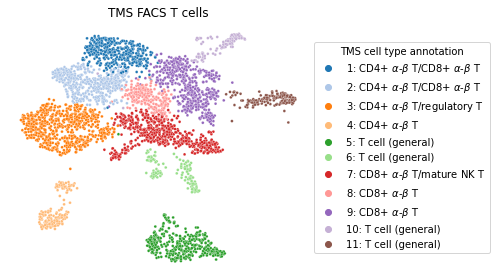

In [7]:
adata = dic_data_proc['tms_facs'].copy()
tissue_list = sorted(adata.obs['tissue'].unique())
print('n_tissue=%d, %s'%(len(tissue_list), ','.join(tissue_list)))
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]}, dtype=float)
df_plot = df_plot.join(adata.obs[['leiden_reorder', 'leiden_anno']])
df_plot['label'] = ['%s: %s'%(x,y) for x,y in zip(df_plot['leiden_reorder'], df_plot['leiden_anno'])]
df_plot['label'] = df_plot['label'].astype('category')

hue_list = []
for x in df_plot['leiden_reorder'].cat.categories:
    for y in set(df_plot['label']):
        if y.startswith('%s: '%x):
            hue_list.append(y)

plt.figure(figsize=[7,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='label', s=8, palette='tab20', hue_order=hue_list)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title="TMS cell type annotation")
plt.title('TMS FACS T cells')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/tcell_tms_annot_umap.svg')
plt.show()

### Subpolulation of associated cells 

In [8]:
# Get adata and association labels
ds,score = 'tms_facs','tms_facs'

# Get adata_assoc
adata_assoc = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata_assoc.obs = adata_assoc.obs.join(temp_adata.obs[
    [x for x in temp_adata.obs.columns if x not in adata_assoc.obs.columns]
])
adata_assoc.obsm = temp_adata.obsm.copy()
adata_assoc.obs['leiden_reorder'] = [str(x) for x in adata_assoc.obs['leiden_reorder']]
del temp_adata
        
# Add cell cycle S_score and G2M_score : proliferation
cc_genes = pd.read_csv(DATA_PATH+'/gene_annotation/Macosko_cell_cycle_genes.txt', sep='\t')
s_genes = [DIC_MAP_H2M[x] for x in cc_genes['S'] if x in DIC_MAP_H2M]
s_genes = list(set(s_genes) & set(adata_assoc.var_names))
g2m_genes = [DIC_MAP_H2M[x] for x in cc_genes['G2.M'] if x in DIC_MAP_H2M]
g2m_genes = list(set(g2m_genes) & set(adata_assoc.var_names))
sc.tl.score_genes_cell_cycle(adata_assoc, s_genes=s_genes, g2m_genes=g2m_genes)

# Define signifincant populations
dic_sig_group = {}
dic_top_group = {}
adata_assoc.obs = adata_assoc.obs.join(dic_score[score][['%s.fdr'%x for x in DIC_TRAIT_LIST[ds]]])
adata_assoc.obs = adata_assoc.obs.join(dic_score[score][['%s.norm_score'%x for x in DIC_TRAIT_LIST[ds]]])
for trait in DIC_TRAIT_LIST[ds]:
    # 'leiden_sig_full.{trait}' : leiden for significant cells (FDR<0.1)
    # 'leiden_sig.{trait}' : leiden for significant cells (FDR<0.1) in major clusters (>25 sig. cells)
    adata_assoc.obs['leiden_sig_full.%s'%trait] = [
        '%s.sig'%x if y<0.1 else 'nonsig' 
        for x,y in zip(adata_assoc.obs['leiden_reorder'], adata_assoc.obs['%s.fdr'%trait])
    ]
    
    adata_assoc.obs['leiden_sig.%s'%trait] = adata_assoc.obs['leiden_sig_full.%s'%trait].copy()
    temp_df = adata_assoc.obs.groupby(['leiden_sig.%s'%trait]).agg({'cell':len})
    cluster_removal_list = list(temp_df.index[temp_df['cell']<25]) #+ ['10.sig']
    ind_remove = adata_assoc.obs['leiden_sig.%s'%trait].isin(cluster_removal_list)
    adata_assoc.obs.loc[ind_remove, 'leiden_sig.%s'%trait] = 'nonsig' 
    
    # dic_sig_group : all leiden_sig groups
    # dic_top_group : top 4 leiden_sig groups
    dic_sig_group[trait] = [
        int(x.replace('.sig','')) for x in adata_assoc.obs['leiden_sig.%s'%trait].unique() if '.sig' in x]
    dic_sig_group[trait] = ['%d.sig'%x for x in sorted(dic_sig_group[trait])]
    
    temp_df = adata_assoc.obs.groupby('leiden_sig.%s'%trait).agg({'%s.norm_score'%trait:np.mean})
    temp_df.drop('nonsig', inplace=True)
    dic_top_group[trait] = temp_df.sort_values('%s.norm_score'%trait, ascending=False).index[:4]
    dic_top_group[trait] = [x for x in dic_sig_group[trait] if x in dic_top_group[trait]]
    
    # Do a summary here ... 
    print('|{:^8s}|{:^20s}|{:^80s}|'.format(
        DF_TRAIT_INFO.loc[trait, 'Code'], 
        'n_sig = %4d/%d'%((adata_assoc.obs['%s.fdr'%trait]<0.1).sum(), adata_assoc.shape[0]),
        ', '.join(['%s %d/%d'%(x, (adata_assoc.obs['leiden_sig.%s'%trait]==x).sum(), 
                                (adata_assoc.obs['leiden_reorder']==x.split('.')[0]).sum())
                  for x in dic_top_group[trait]])
    ))
#     display(temp_df.sort_values('%s.norm_score'%trait, ascending=False))

|  IBD   | n_sig =  387/3769  |            3.sig 123/629, 4.sig 78/165, 5.sig 85/370, 9.sig 41/499             |
|   CD   | n_sig =  237/3769  |                    3.sig 54/629, 4.sig 53/165, 5.sig 51/370                    |
|   UC   | n_sig =   25/3769  |                                                                                |
|   RA   | n_sig = 1517/3769  |           1.sig 156/402, 3.sig 342/629, 4.sig 52/165, 9.sig 272/499            |
|   MS   | n_sig =  887/3769  |            3.sig 146/629, 4.sig 41/165, 5.sig 96/370, 9.sig 141/499            |
|  AIT   | n_sig = 1638/3769  |           3.sig 445/629, 4.sig 74/165, 5.sig 189/370, 9.sig 284/499            |
|   HT   | n_sig = 1484/3769  |           3.sig 449/629, 4.sig 63/165, 9.sig 258/499, 10.sig 44/112            |
| Eczema | n_sig =  924/3769  |           1.sig 103/402, 3.sig 287/629, 4.sig 82/165, 5.sig 132/370            |
|  ASM   | n_sig =  892/3769  |           3.sig 200/629, 4.sig 77/165, 5.sig 161/370, 9.sig 127/

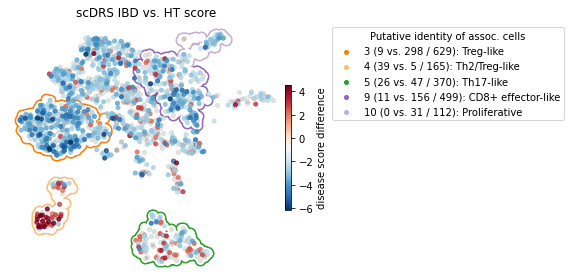

In [9]:
# UMAP for score differences of IBD vs. other pairs
def num2str(x):
    return '%d'%x if x>=25 else '-'
cmap = matplotlib.cm.get_cmap('tab20')

trait1 = 'PASS_IBD_deLange2017'

for trait2 in ['UKB_460K.disease_HYPOTHYROIDISM_SELF_REP']:
    # Get df_plot 
    df_plot = pd.DataFrame(index=adata_assoc.obs_names, 
                           data={'UMAP1':adata_assoc.obsm['X_umap'][:,0],
                                 'UMAP2':adata_assoc.obsm['X_umap'][:,1]})
    df_plot = df_plot.join(adata_assoc.obs[
        ['leiden_reorder', 'cell', '%s.norm_score'%trait1, '%s.norm_score'%trait2]
    ])
    df_plot['norm_score_dif'] = df_plot['%s.norm_score'%trait1] - df_plot['%s.norm_score'%trait2]
    df_plot['abs_norm_score_dif'] = np.absolute(df_plot['norm_score_dif'])
    df_plot.sort_values('abs_norm_score_dif', ascending=True, inplace=True)

    df_plot['leiden_sig1'] = ['%s.sig'%x if y>2 else 'nonsig'
                              for x,y in zip(df_plot['leiden_reorder'], df_plot['norm_score_dif'])]
    df_plot['leiden_sig2'] = ['%s.sig'%x if y<-2 else 'nonsig'
                              for x,y in zip(df_plot['leiden_reorder'], df_plot['norm_score_dif'])]
    df_plot['leiden_sig'] = ['%s.sig'%x if y>2 else 'nonsig'
                              for x,y in zip(df_plot['leiden_reorder'], df_plot['abs_norm_score_dif'])]
    
    if trait2 in ['UKB_460K.disease_HYPOTHYROIDISM_SELF_REP']:
        # Main fig
        group_list = set(dic_top_group[trait1]) | set(dic_top_group[trait2])
        dic_config = {
            '3.sig' : ['3 @a: Treg-like'], 
            '4.sig' : ['4 @a: Th2/Treg-like'],
            '5.sig' : ['5 @a: Th17-like'],
            '9.sig' : ['9 @a: CD8+ effector-like'],
            '10.sig' : ['10 @a: Proliferative'],
        }
        title_ = 'Putative identity of assoc. cells'
        figsize_ = [8,4]
    else:
        # Supp. fig
        temp_df = df_plot.groupby('leiden_sig').agg({'cell' : len})
        group_list = list(temp_df.index[temp_df['cell']>=10])
        dic_config = { x : ['%s @a'%x.split('.')[0]] for x in group_list}
        title_ = 'Clusters'
        figsize_ = [6.5,4]
    
    group_list = [int(x.replace('.sig','')) for x in group_list if x!='nonsig']
    group_list = ['%d.sig'%x for x in sorted(group_list)]
   
    # Figure 
    plt.figure(figsize=figsize_)
    ax = plt.subplot(1,1,1)
    ax.axis('off')

    # Cluster boundry 
    x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
    y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
    for cluster in group_list:
        ind_select = df_plot['leiden_reorder']==cluster.split('.')[0]
        assoc_str = '(%s vs. %s / %s)'%(
            (ind_select&(df_plot['leiden_sig1']!='nonsig')).sum(), 
            (ind_select&(df_plot['leiden_sig2']!='nonsig')).sum(),
            ind_select.sum()
        )
        temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
        xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
        xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
        ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
        ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
        ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                        (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                    s=16, color=cmap(int(cluster.split('.')[0])-1),
                    label=dic_config[cluster][0].replace('@a',assoc_str), zorder=0)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=120, color=cmap(int(cluster.split('.')[0])-1), zorder=1)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=60, color='w', zorder=2)
    
    # Grey for non-sig cells 
    np.random.seed(0)
    ind_select_sig = (df_plot['leiden_sig']!='nonsig')
    cell_list_nonsig = np.random.choice(
        df_plot.index[~ind_select_sig], size=int((~ind_select_sig).sum()*0.2), replace=False)
    plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)
    
    # Red for sig cells 
    vmax = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.01) - 0.5
    plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
                c=df_plot.loc[ind_select_sig, 'norm_score_dif'],
                cmap='RdBu_r', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
    plt.colorbar(shrink=0.5, pad=0, label='disease score difference')
    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left',
               title=title_)
    plt.title('scDRS %s vs. %s score'%(DF_TRAIT_INFO.loc[trait1, 'Code'], DF_TRAIT_INFO.loc[trait2, 'Code']))

    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.%s.svg'%(score, trait1, trait2))
#     plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.%s.png'%(score, trait1, trait2))
    plt.show()

### Annotating associated cells : UMAP plots 
- PASS_IBD_deLange2017 
- UKB_460K.disease_HYPOTHYROIDISM_SELF_REP  

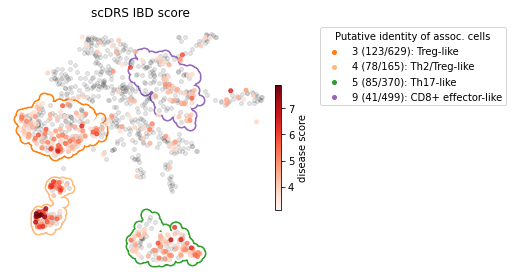

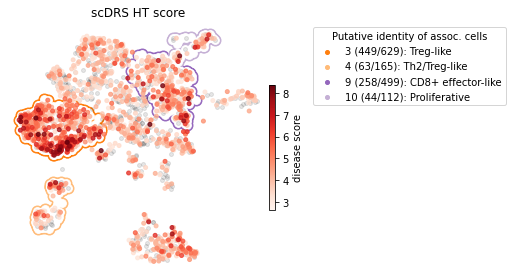

In [10]:
# UMAP plot with annotations
trait_list = ['PASS_IBD_deLange2017', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP']
dic_config = {}

dic_config['PASS_IBD_deLange2017'] = {
    '3.sig' : ['3 @a: Treg-like'], 
    '4.sig' : ['4 @a: Th2/Treg-like'],
    '5.sig' : ['5 @a: Th17-like'], 
    '9.sig' : ['9 @a: CD8+ effector-like']
}

dic_config['UKB_460K.disease_HYPOTHYROIDISM_SELF_REP'] = {
    '3.sig' : ['3 @a: Treg-like'], 
    '4.sig' : ['4 @a: Th2/Treg-like'],
    '9.sig' : ['9 @a: CD8+ effector-like'],
    '10.sig' : ['10 @a: Proliferative'],
}
cmap = matplotlib.cm.get_cmap('tab20')

for trait in trait_list:
    # Get df_plot 
    df_plot = pd.DataFrame(index=adata_assoc.obs_names, 
                           data={'UMAP1':adata_assoc.obsm['X_umap'][:,0],
                                 'UMAP2':adata_assoc.obsm['X_umap'][:,1]})
    df_plot = df_plot.join(adata_assoc.obs[
        ['leiden_reorder', 'cell', 
         '%s.fdr'%trait, '%s.norm_score'%trait, 'leiden_sig.%s'%trait, 'leiden_sig_full.%s'%trait]
    ])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    for x in dic_top_group[trait]:
        if x not in dic_config[trait]:
            dic_config[trait][x] = ['%s @a'%x.split('.')[0]]

    # Figure 
    plt.figure(figsize=[7.2,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')

    # Cluster boundry 
    x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
    y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
    for cluster in dic_top_group[trait]:
        ind_select = df_plot['leiden_reorder']==cluster.split('.')[0]
        assoc_str = '(%d/%d)'%((ind_select&(df_plot['leiden_sig.%s'%trait]!='nonsig')).sum(), ind_select.sum())
        temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
        xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
        xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
        ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
        ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
        ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                        (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                    s=16, color=cmap(int(cluster.split('.')[0])-1),
                    label=dic_config[trait][cluster][0].replace('@a',assoc_str), zorder=0)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=120, color=cmap(int(cluster.split('.')[0])-1), zorder=1)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=60, color='w', zorder=2)

    ind_select_sig = (df_plot['leiden_sig_full.%s'%trait]!='nonsig')
    np.random.seed(0)
    cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                        size=int((~ind_select_sig).sum()*0.2), replace=False)
    plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                    c='k', s=16, alpha=0.1, zorder=5)

    vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
                c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
                cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
    plt.colorbar(shrink=0.5, pad=0, label='disease score')
    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', title='Putative identity of assoc. cells')
    plt.title('scDRS %s score'%DF_TRAIT_INFO.loc[trait, 'Code'])
    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc_annot.%s.%s.svg'%(score, trait))
    plt.show()

### CD4/CD8 effector gradients

dpt_cd4_qn n_cell=1686, clusters=1,2,3,4


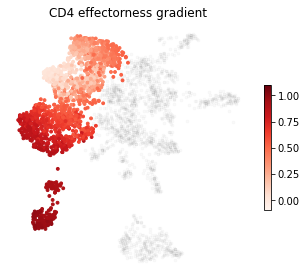

dpt_cd8_qn n_cell=2197, clusters=1,2,7,8,9


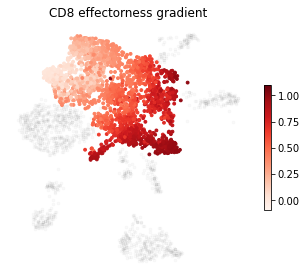

In [11]:
# Pseudotime: make it nicer later 
ds='tms_facs'
adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
dic_title = {'dpt_cd4_qn': 'CD4 effectorness gradient', 'facs_cd4': 'CD4 effectorness gradient',
             'dpt_cd8_qn': 'CD8 effectorness gradient', 'facs_cd8': 'CD8 effectorness gradient'}
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['dpt_cd4_qn', 'dpt_cd8_qn', 'leiden_reorder']])

for term in ['dpt_cd4_qn', 'dpt_cd8_qn']:    
    plt.figure(figsize=[4.5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    ind_select = df_plot[term]>=0
    print('%s n_cell=%d, clusters=%s'%(term, ind_select.sum(), 
                                       ','.join([str(x) for x in sorted(set(df_plot.loc[ind_select,
                                                                                        'leiden_reorder']))])))
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', alpha=0.025, s=8)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, term], cmap='Reds', vmax=1.1, vmin=-0.1, s=8)
    plt.colorbar(shrink=0.5)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(dic_title[term])
    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/%s.svg'%term)
#     plt.savefig(FIG_PATH+'/%s.png'%term)
    plt.show()

In [12]:
# Prepare regression datasets 
n_ctrl = 1000 
dic_cov = {}

# FACS CD4 
dic_cov['facs_cd4'] = dic_data_proc['tms_facs'].obs.copy()
dic_cov['facs_cd4']['effectorness'] = dic_cov['facs_cd4']['dpt_cd4_qn']
dic_cov['facs_cd4'] = dic_cov['facs_cd4'].loc[dic_cov['facs_cd4']['effectorness']>0].copy()

# FACS CD8 
dic_cov['facs_cd8'] = dic_data_proc['tms_facs'].obs.copy()
dic_cov['facs_cd8']['effectorness'] = dic_cov['facs_cd8']['dpt_cd8_qn']
dic_cov['facs_cd8'] = dic_cov['facs_cd8'].loc[dic_cov['facs_cd8']['effectorness']>0].copy()

# Add const and leiden
for cov_name in dic_cov:
    dic_cov[cov_name]['const'] = 1
    for cluster in set(dic_cov[cov_name]['leiden_reorder']):
        if (dic_cov[cov_name]['leiden_reorder']==cluster).sum()>0:
            dic_cov[cov_name]['leidenreg_%d'%cluster] = (dic_cov[cov_name]['leiden_reorder']==cluster)*1

In [13]:
# Regression analysis
dic_reg = {'reg_marginal': ['effectorness'],
           'reg_joint': ['effectorness', 'leidenreg']
          }

dic_stats = {}
for cov_name in dic_cov:
    for reg_name in dic_reg:
        print(cov_name, reg_name)
        reg_list = dic_reg[reg_name].copy()
        if 'leidenreg' in reg_list:
            reg_list.remove('leidenreg')
            ctrl_list = ['const'] + [x for x in dic_cov[cov_name].columns if 'leidenreg' in x]
        else:
            ctrl_list = ['const']
        df_stats = pd.DataFrame(columns=['var_ctrl','var']+['%s.%s'%(y,x) for x in reg_list for y in ['T', 'P']])
        ds = cov_name.split('_' )[0]
        
        for score in ['tms_facs']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    print('Missing', score, '%s.norm_score'%trait)
                    continue              

                df_reg = dic_cov[cov_name][reg_list+ctrl_list].copy()
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list]).fit()
                var_explain_ctrl_ = 1 - res.mse_resid/res.mse_total

                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list+reg_list]).fit()
                var_explain_ = 1 - res.mse_resid/res.mse_total
                dic_t = {x:res.tvalues[x] for x in reg_list}
                dic_t_ctrl = {x:np.zeros(n_ctrl) for x in reg_list}

                for i in range(n_ctrl):
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i], df_reg[ctrl_list+reg_list]).fit()
                    for reg in reg_list:
                        dic_t_ctrl[reg][i] = res.tvalues[reg]
                if trait in ['naive_cd4', 'naive_cd8']:
                    dic_p = {x:((dic_t[x] >= dic_t_ctrl[x]).sum()+1) / (n_ctrl+1) for x in reg_list} 
                else:
                    dic_p = {x:((dic_t[x] <= dic_t_ctrl[x]).sum()+1) / (n_ctrl+1) for x in reg_list} 
                df_stats.loc[trait] = [var_explain_ctrl_, var_explain_] + \
                    [y[x] for x in reg_list for y in [dic_t, dic_p]]

        for reg_term in reg_list:
            df_stats['P_STR.%s'%reg_term] = [scdrs.util.p_2_str(x) for x in df_stats['P.%s'%reg_term]]
            df_stats['P_STR_NUM.%s'%reg_term] = [scdrs.util.p_2_str_num(x,n_ctrl) for x in df_stats['P.%s'%reg_term]]
        dic_stats['%s.%s'%(cov_name, reg_name)] = df_stats

facs_cd4 reg_marginal
facs_cd4 reg_joint
facs_cd8 reg_marginal
facs_cd8 reg_joint


In [14]:
# Output table: Association p-values
trait_list = DIC_TRAIT_LIST['tms_facs'].copy()
df_res = pd.DataFrame(index=trait_list)
df_res['Trait'] = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_res.index]

for cov_name in dic_cov:
    term = 'CD4' if cov_name=='facs_cd4' else 'CD8'
    # Marginal regression
    temp_df = dic_stats['%s.reg_marginal'%(cov_name)][['P.effectorness', 'var']].copy()
    temp_df.columns = ['%s.P'%term, '%s.Var'%term]
    df_res = df_res.join(temp_df)
    
    # Joint regression 
    temp_df = dic_stats['%s.reg_joint'%(cov_name)][['var_ctrl', 'var', 'P.effectorness']]
    temp_df.columns = ['%s.Var.cluster'%term, '%s.Var.joint'%term, '%s.P.joint'%term]
    df_res = df_res.join(temp_df)
    
df_res = df_res[['Trait', 'CD4.P', 'CD4.Var', 'CD4.P.joint', 'CD8.P', 'CD8.Var', 'CD8.P.joint', ]]
for col in ['CD4.P', 'CD4.P.joint', 'CD8.P', 'CD8.P.joint']:
    df_res[col] = ['$\textbf{%0.3f}$'%x if x<0.005 else '$%0.3f$'%x for x in df_res[col]]
for col in ['CD4.Var', 'CD8.Var']:
    df_res[col] = ['%0.3f'%x for x in df_res[col]]
print(df_res.to_latex(index=False, escape=False, column_format='|c|cc|c|cc|c|'))

\begin{tabular}{|c|cc|c|cc|c|}
\toprule
  Trait &             CD4.P & CD4.Var &       CD4.P.joint &    CD8.P & CD8.Var & CD8.P.joint \\
\midrule
    IBD &  $\textbf{0.001}$ &   0.282 &  $\textbf{0.005}$ &  $0.021$ &   0.083 &     $0.022$ \\
     CD &  $\textbf{0.001}$ &   0.202 &  $\textbf{0.004}$ &  $0.026$ &   0.087 &     $0.006$ \\
     UC &  $\textbf{0.004}$ &   0.159 &           $0.069$ &  $0.441$ &  -0.000 &     $0.545$ \\
     RA &           $0.118$ &   0.024 &           $0.269$ &  $0.261$ &   0.006 &     $0.568$ \\
     MS &           $0.223$ &   0.009 &           $0.239$ &  $0.129$ &   0.020 &     $0.420$ \\
    AIT &  $\textbf{0.002}$ &   0.188 &           $0.007$ &  $0.038$ &   0.064 &     $0.193$ \\
     HT &  $\textbf{0.003}$ &   0.153 &           $0.034$ &  $0.100$ &   0.028 &     $0.265$ \\
 Eczema &           $0.011$ &   0.087 &           $0.250$ &  $0.819$ &   0.016 &     $0.889$ \\
    ASM &           $0.035$ &   0.059 &           $0.387$ &  $0.325$ &   0.001 &     $0

facs_cd4 ['UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 'PASS_IBD_deLange2017', 'UKB_460K.body_HEIGHTz'] (1685, 36)


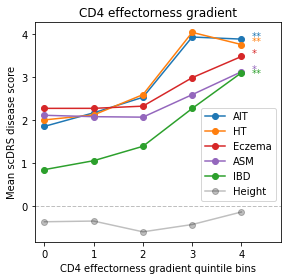

facs_cd8 ['UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 'PASS_IBD_deLange2017', 'UKB_460K.body_HEIGHTz'] (2196, 37)


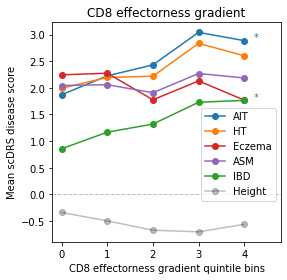

In [15]:
# Traits
score = 'tms_facs'
trait_list = [
    'UKB_460K.disease_AID_ALL',
    'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 
    'UKB_460K.disease_ASTHMA_DIAGNOSED',
    'PASS_IBD_deLange2017',  
    'UKB_460K.body_HEIGHTz'
             ]
dic_config_trait = {
    'UKB_460K.disease_AID_ALL': ['C0'], 
    'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP': ['C1'], 
    'PASS_IBD_deLange2017': ['C2'], 
    'PASS_CD_deLange2017': ['C8'], 
    'PASS_UC_deLange2017': ['C9'], 
    'PASS_Rheumatoid_Arthritis': ['C5'],
    'UKB_460K.disease_RESPIRATORY_ENT' : ['C6'],
    'UKB_460K.disease_ASTHMA_DIAGNOSED' : ['C4'],
    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED' : ['C3'],
    'PASS_Multiple_sclerosis' : ['C7'],
    'UKB_460K.body_HEIGHTz' : ['k']
                   }

for cov_name in ['facs_cd4', 'facs_cd8']:
    df_plot = dic_cov[cov_name].copy()
    df_plot = df_plot.join(dic_score[score][['%s.norm_score'%x for x in trait_list]])
    df_plot['bin'] = pd.qcut(df_plot['effectorness'], q=5, labels=False)
    print(cov_name, trait_list, df_plot.shape)
    
    plt.figure(figsize=[4.1,4])
    i_color = 0
    y_text = 5
    for trait in trait_list:
        alpha_=0.25 if trait=='UKB_460K.body_HEIGHTz' else 1
#         color_='k' if trait=='UKB_460K.body_HEIGHTz' else 'C%d'%i_color
        color_=dic_config_trait[trait][0]
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%trait], 'o-', 
                 label=DF_TRAIT_INFO.loc[trait, 'Code'], color=color_, alpha=alpha_)
        if cov_name=='facs_cd4':
            y_text = min(y_text-0.1, temp_df['%s.norm_score'%trait][4])
        else:
            y_text = temp_df['%s.norm_score'%trait][4]
        plt.text(4.2, y_text, dic_stats['%s.reg_marginal'%cov_name].loc[trait,'P_STR.effectorness'], 
                 color=color_, alpha=alpha_)
        i_color+=1
    plt.axhline(y=0, ls="--", color="k", lw=1, alpha=0.25)
    plt.xlim([-0.2,4.8])
    plt.legend(loc='center right', bbox_to_anchor=[1,0.4])
    plt.xlabel('%s quintile bins'%dic_title[cov_name])
    plt.ylabel('Mean scDRS disease score')
    plt.title(dic_title[cov_name])
    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/dpt_trait_corr.%s.svg'%cov_name)
    plt.show()
#     break